In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
import skewer_computations as skc
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d

import mask_calculations as mc
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck18 as P18


Load the data

In [2]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
# set phase
phase = "sim_minus"
# set axis number
axis = 1

In [3]:
# load the skewers x 
system='PIC'
if system=='PIC':
    meas_path = "/data/desi/common/HydroData/Emulator/post_768/"
    delta_x = np.load(meas_path+"/delta_x/central/skewers_{:d}_p{:s}_ax{:d}_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num, phase, axis))
elif system=='home':
    meas_path = "/Users/mlokken/research/lyman_alpha/data/"
    delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_{:d}_p{:s}_ax{:d}_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num, phase, axis))

delta_flux_x = delta_x['delta_flux_x']
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
xpar = delta_x['xpar']
delta_x.close()

pixel spacing is 0.05 Mpc


Load the model

In [ ]:
# get the model

path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

In [ ]:
# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)

In [ ]:
# input the details into the ArinyoModel class
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], np.linspace(0,10,20), parameters=arinyo_params) # get P1D at target z

In [4]:
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 1
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
if binsize!=1:
    delta_flux, xpar = est.bin_spectra(delta_flux_x, xpar, binsize)
    del delta_flux_x
else:
    delta_flux = np.copy(delta_flux_x)
    del delta_flux_x
Np=delta_flux.shape[1]
pix_spacing = xpar[1]-xpar[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing} Mpc")
delta_flux_k = np.fft.fft(delta_flux)
kpar = np.fft.fftfreq(Np, pix_spacing)*2*np.pi # frequency in Mpc^-1
Nk = delta_flux_k.shape[1]
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])

subsample = True
if subsample:
    subfac = 15
    delta_flux = delta_flux[::subfac]
    delta_flux_k = delta_flux_k[::subfac]
    positions = positions[::subfac]
nskew = delta_flux.shape[0]

Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Spacing between pixels along line-of-sight after binning = 0.05000000000000001 Mpc
spacing between neighboring skewers is 0.09 Mpc


0.06917567616895992 redshift
0.0002562062080331849 redshift
0.3115467489683528
Ca K rest frame [983.25 983.95]
Ca H rest frame [991.825 992.75 ]
Number of pixels covered by Ca K 2.2468538102804985
Number of pixels covered by Ca H 2.9690568207274626
Pixels separating Ca K and Ca H 25.277105365653966


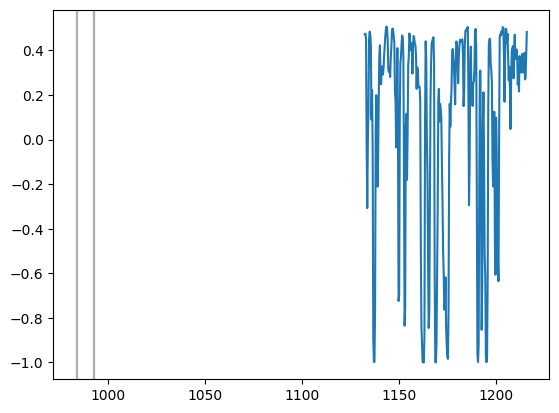

In [195]:
# act like the box spans a small range in redshift
z_box_center = zs[0]
zlow, zhi = z_at_value(P18.comoving_distance, P18.comoving_distance(z_box_center)-L/2*u.Mpc), z_at_value(P18.comoving_distance, P18.comoving_distance(z_box_center)+L/2*u.Mpc)
print(zhi-zlow)
dz_pix = (zhi-zlow)/Np
print(dz_pix)
delta_lambda = 1216 * dz_pix.value
print(delta_lambda)
# now figure out what the calcium lines would be in the rest frame of the 'quasar'
# check the true Calcium lines masking widths
Ca_K_obs = np.array([3933,3935.8]) # OBSERVED wavelength in Angstrom
Ca_H_obs = np.array([3967.3, 3971.0])
sky      = np.array([5570.5, 5586.5])
Ca_K_rest = Ca_K_obs/(1+zs[0])
Ca_H_rest = Ca_H_obs/(1+zs[0])
sky_rest  = sky/(1+zs[0])
print("Ca K rest frame", Ca_K_rest)
print("Ca H rest frame", Ca_H_rest)
print("Skyline rest frame", sky_rest)
Ca_K_width_lambda = Ca_K_rest[1]-Ca_K_rest[0]
Ca_K_width_pix = Ca_K_width_lambda/delta_lambda
print("Lambda spanned by Ca K", Ca_K_width_lambda)
print("Number of pixels covered by Ca K", Ca_K_width_pix)
print("Distance in Mpc spanned by Ca K", Ca_K_width_pix*pix_spacing)
Ca_H_width_lambda = Ca_H_rest[1]-Ca_H_rest[0]
Ca_H_width_pix = Ca_H_width_lambda/delta_lambda
print("Lambda spanned by Ca H", Ca_H_width_lambda)
print("Number of pixels covered by Ca H", Ca_H_width_pix)
print("Distance in Mpc spanned by Ca H", Ca_H_width_pix*pix_spacing)

skyline_width_lambda = sky_rest[1]-sky_rest[0]
skyline_width_pix = (sky_rest[1]-sky_rest[0])/delta_lambda
print("Lambda spanned by Skyline", skyline_width_lambda)
print("Number of pixels covered by Skyline", skyline_width_pix)
npix_sep = (Ca_H_rest[0]-Ca_K_rest[1])/delta_lambda
print("Pixels separating Ca K and Ca H", npix_sep)
print("Distance in Mpc between Ca K and Ca H", npix_sep*pix_spacing)
print("Distance in lambda space", npix_sep*delta_lambda)

H_z = camb_results.hubble_parameter(zs[0])
delta_flux_wavelength = 1216-1216*(np.arange(Np)*L/Np * H_z/(3*10**5))
plt.plot(delta_flux_wavelength, delta_flux_x[0,:])
plt.axvspan(Ca_K_rest[0], Ca_K_rest[1], alpha=0.5, color='grey')
plt.axvspan(Ca_H_rest[0], Ca_H_rest[1], alpha=0.5, color='grey')
plt.axvspan(sky_rest[0], sky_rest[1], alpha=0.5, color='grey')

In [5]:
# match the total number of pixels masked to what is necessary for the skyline version
skyline_width = 30
Npmasked_total = skyline_width * nskew
Npm_per_skew = skyline_width
boxdiv = 4
masks_exist = True
double_skyline_width = int(skyline_width//2)
print("double skyline width", double_skyline_width)
double_skyline_distance = 125
double_sky_maskrange = np.arange(int(Np//boxdiv), int(Np//boxdiv)+double_skyline_width)
sky_maskrange = np.arange(Np//boxdiv, Np//boxdiv+skyline_width)
nmasked_skyline = skyline_width*nskew
dla_width = 400
dla_width_small = 40
print("DLA width in Mpc is", dla_width*pix_spacing)
ndla = int(Npmasked_total // dla_width)
print("N DLA:", ndla)

if not masks_exist:
    # in the subselected forest, do some masking schemes along the line-of-sight axis
    # 1: random masking of 1-5 pixels in each skewer for every line of sight
    print("Doing random masking")
    
    random_mask = np.ones((nside, nside, Np)) # store the mask
    
    masklocs_per_skewer = []
    nmasked_rand = 0
    for i in range(nside):
        for j in range(nside):
            nmask = rng.integers(Npm_per_skew-int(skyline_width/2.), Npm_per_skew+int(skyline_width/2.)+1) # average # of pixels masked will be Npm_per_skew
            if nmask != 0:
                masklocs = rng.choice(np.arange(Np), size=nmask, replace=False)
                masklocs_per_skewer.append(masklocs)
                nmasked_rand += nmask
                random_mask[i,j, masklocs] = 0
    print("Total number of pixels masked in random scheme is", nmasked_rand/Npmasked_total*100, "percent of the total desired")
    
    # 2: 'skyline-like' masking: mask a range of N pixels 1/x of the way through the box
    print("Doing single-skyline masking")
    print("total number of pixels masked in skyline scheme is", nmasked_skyline/Npmasked_total*100, "percent of the total desired")
    skyline_mask = np.ones((nside, nside, Np)) # store the mask
    skyline_mask[:, :, sky_maskrange] = 0
    
    # 3: put a DLA-like mask (20 pixels at once) at random positions
    print("Doing DLA masking")
    
    nmasked_dla = 0
    dla_mask = np.ones((nside, nside, Np)) # store the mask
    # get all indices
    dla_locs_xx, dla_locs_yy = np.indices((nside, nside))
    if ndla!=nside**2:
        dla_locs_xx = rng.choice(dla_locs_xx.ravel(), size=ndla, replace=False)
        dla_locs_yy = rng.choice(dla_locs_yy.ravel(), size=ndla, replace=False)
    else:
        dla_locs_xx = dla_locs_xx.ravel()
        dla_locs_yy = dla_locs_yy.ravel()
    dla_locs_zstart = rng.choice(np.arange(Np-dla_width), size=ndla, replace=True)
    for i in range(ndla):
        z_start = dla_locs_zstart[i]
        z_end  = z_start + dla_width
        nmasked_dla += dla_width
        dla_mask[dla_locs_xx[i], dla_locs_yy[i], z_start:z_end] = 0
    print("total number of pixels masked in DLA scheme is", nmasked_dla/Npmasked_total*100, "percent of the total desired")
    
    #4: double skyline-like masking: mask 1 pixel 1/x of the way through the box and another pixel 1/x+2 of the way through the box
    print("Doing double-skyline masking")
    nmasked_2skyline = double_skyline_width*2*nskew
    print("total number of pixels masked in double skyline scheme is", nmasked_2skyline/Npmasked_total*100, "percent of the total desired")
    
    skyline_2mask = np.ones((nside, nside, Np)) # store the mask
    skyline_2mask[:, :, double_sky_maskrange] = 0
    skyline_2mask[:, :, double_sky_maskrange+double_skyline_distance] = 0

double skyline width 15
DLA width in Mpc is 20.000000000000004
N DLA: 2949


In [15]:
if masks_exist:
    # read the masks
    maskdir = "/data/desi/scratch/mlokken/masking/"
    masks = []
    random_mask  = np.load(maskdir+'random_mask.npy')
    skyline_mask = np.load(maskdir+'skyline_mask.npy')
    skyline_2mask = np.load(maskdir+'double_skyline_mask.npy')
    dla_mask = np.load(maskdir+'dla_mask.npy')
    dla_mask_small = np.load(maskdir+'dla_mask_small.npy')
if subsample:
    random_mask = random_mask[::subfac]
    skyline_mask = skyline_mask[::subfac]
    skyline_2mask = skyline_2mask[::subfac]
    dla_mask = dla_mask[::subfac]
    dla_mask_small = dla_mask_small[::subfac]

delta_flux_2skyline = skyline_2mask * delta_flux
delta_flux_skyline  = skyline_mask * delta_flux
delta_flux_randmask = random_mask * delta_flux
delta_flux_dla      = dla_mask * delta_flux
delta_flux_dla_small = dla_mask_small * delta_flux

In [7]:
pad = False
if pad:
    # incorporate the larger mask (zero padding, ish) if desired
    delta_flux_grid, padmask_og = mc.skewer_offset_and_pad(delta_flux_grid, rng)
    delta_flux_randmasked_grid, padmask_rand = mc.skewer_offset_and_pad(delta_flux_randmasked_grid, rng)
    delta_flux_skyline_grid, padmask_skyline = mc.skewer_offset_and_pad(delta_flux_skyline_grid, rng)
    delta_flux_dla_grid, padmask_dla = mc.skewer_offset_and_pad(delta_flux_dla_grid, rng)
    delta_flux_2skyline_grid, padmask_2skyline = mc.skewer_offset_and_pad(delta_flux_2skyline_grid, rng)


In [52]:
plt.clf()

<Figure size 640x480 with 0 Axes>

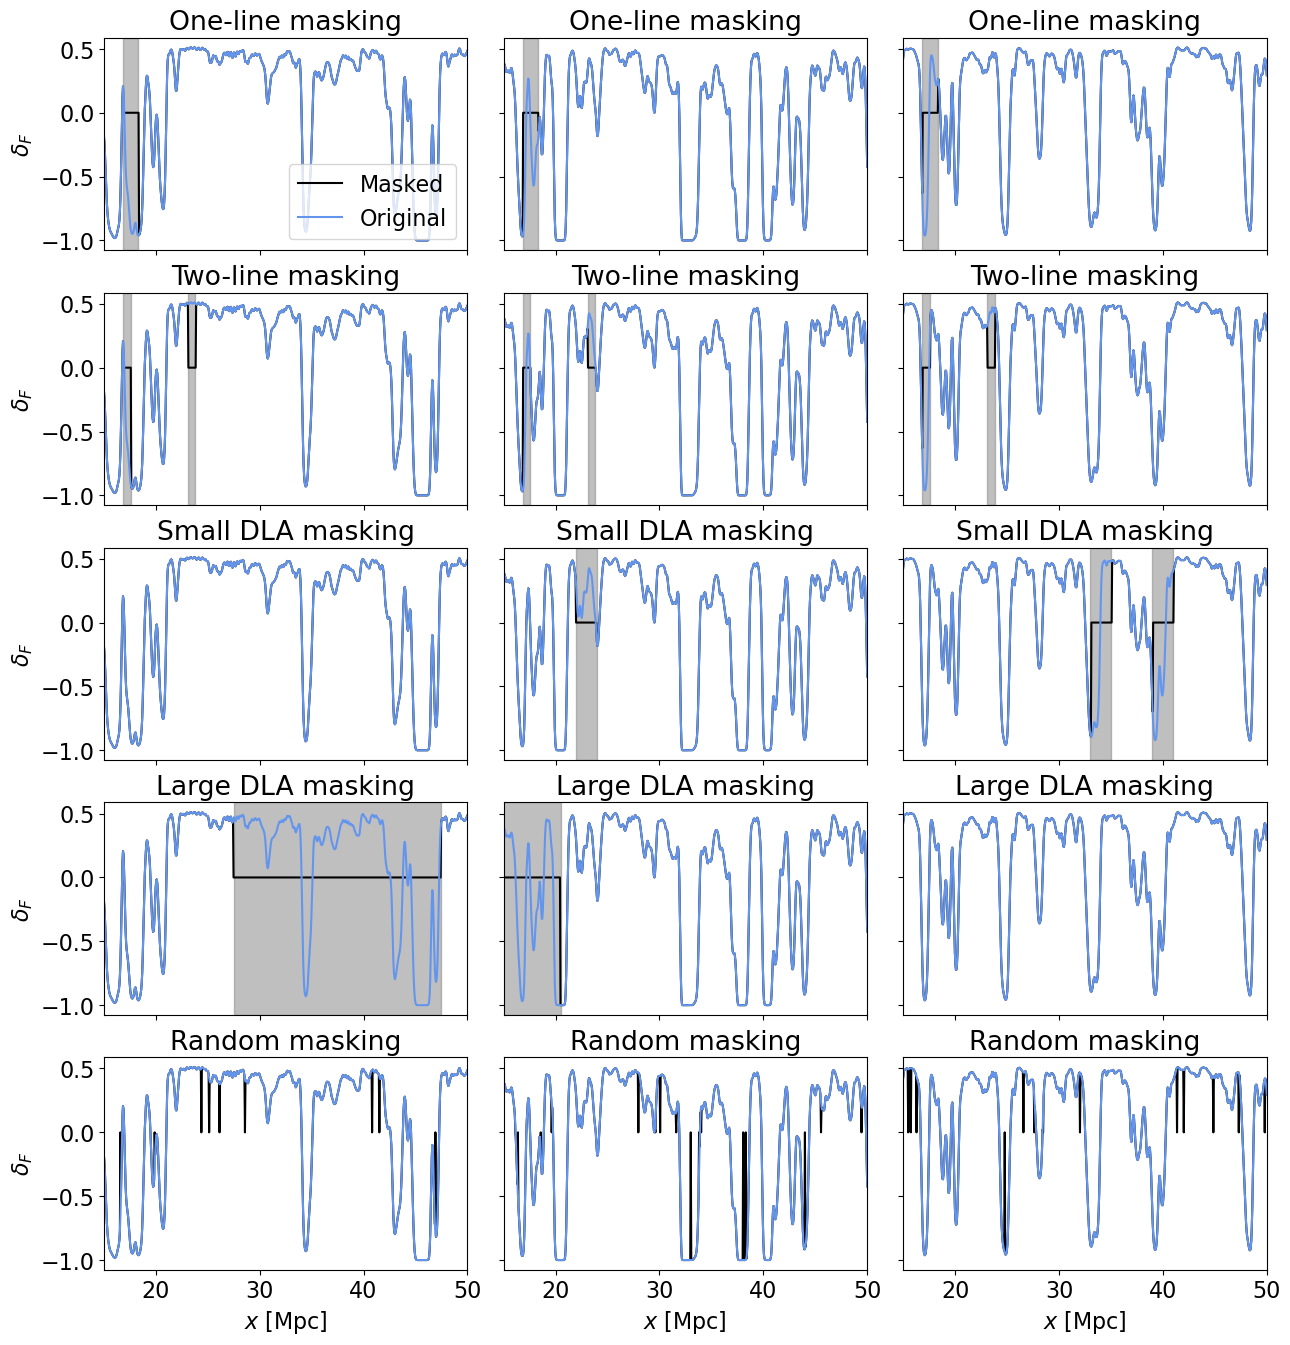

In [55]:
plotmode = 'twol'

# check a few spectra in each
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(5, 3, figsize=(15, 16), sharey=True, sharex=True)
for axj in range(ax.shape[0]):
    
    for axi,i in enumerate([9,51,100]):
        # ax[axi].plot(xpar, delta_flux_dla[i, :], label='Masked', linestyle='dashed')
        
        
        if axj==0:
            ax[axj,axi].plot(xpar, delta_flux_skyline[i, :], label='Masked', color='black')
            ax[axj,axi].plot(xpar, delta_flux[i, :], label='Original', color='cornflowerblue')
            ax[axj,axi].axvspan(sky_maskrange[0]*pix_spacing, sky_maskrange[-1]*pix_spacing, alpha=0.5, color='grey')
            if axi==1:
                ax[axj,axi].set_title("One-line masking")
        elif axj==1:
            ax[axj,axi].plot(xpar, delta_flux_2skyline[i, :], label='Masked', color='black')
            ax[axj,axi].plot(xpar, delta_flux[i, :], label='Original', color='cornflowerblue')
            ax[axj,axi].axvspan(double_sky_maskrange[0]*pix_spacing, double_sky_maskrange[-1]*pix_spacing, alpha=0.5, color='grey')
            ax[axj,axi].axvspan(double_sky_maskrange[0]*pix_spacing+double_skyline_distance*pix_spacing, double_sky_maskrange[-1]*pix_spacing+double_skyline_distance*pix_spacing, alpha=0.5, color='grey')
            if axi==1:
                ax[axj,axi].set_title("Two-line masking")
        elif axj==2:
            ax[axj,axi].plot(xpar, delta_flux_dla_small[i, :], label='DLA', color='black')
            ax[axj,axi].plot(xpar, delta_flux[i, :], label='Original', color='cornflowerblue')
            if axi==1:
                ax[axj,axi].axvspan(22, 22+dla_width_small*pix_spacing, alpha=0.5, color='grey')
                ax[axj,axi].set_title("Small DLA masking")
            elif axi==2:
                ax[axj,axi].axvspan(33, 33+dla_width_small*pix_spacing, alpha=0.5, color='grey')
                ax[axj,axi].axvspan(39, 39+dla_width_small*pix_spacing, alpha=0.5, color='grey')
        elif axj==3:
            ax[axj,axi].plot(xpar, delta_flux_dla[i, :], label='DLA', color='black')
            ax[axj,axi].plot(xpar, delta_flux[i, :], label='Original', color='cornflowerblue')
            if axi==1:
                ax[axj,axi].axvspan(.5, .5+dla_width*pix_spacing, alpha=0.5, color='grey')
                ax[axj,axi].set_title("Large DLA masking")
            elif axi==0:
                ax[axj,axi].axvspan(27.5, 27.5+dla_width*pix_spacing, alpha=0.5, color='grey')
        elif axj==4:
            ax[axj,axi].plot(xpar, delta_flux_randmask[i, :], label='random', color='black')
            ax[axj,axi].plot(xpar, delta_flux[i, :], label='Original', color='cornflowerblue')
            if axi==1:
                ax[axj,axi].set_title("Random masking")
        ax[axj,axi].set_xlim(15,50)
        ax[4,axi].set_xlabel("$x$ [Mpc]")
    ax[axj,0].set_ylabel(r'$\delta_F$')        
ax[0,0].legend(loc='lower right')

plt.subplots_adjust(wspace=0.1, hspace=.2)
plt.savefig("paper/mask_visuals.pdf", bbox_inches='tight')


In [9]:
# FFT the masks
pad = False
if pad:
    skyline_mask_k = np.fft.fft(skyline_mask*padmask_skyline, axis=2)
    skyline_2mask_k = np.fft.fft(skyline_2mask*padmask_2skyline, axis=2)
    dla_mask_k = np.fft.fft(dla_mask*padmask_dla, axis=2)
    random_mask_k = np.fft.fft(random_mask*padmask_rand, axis=2)
else:
    skyline_mask_k = np.fft.fft(skyline_mask.reshape(nskew, Np), axis=1)
    skyline_2mask_k = np.fft.fft(skyline_2mask.reshape(nskew, Np), axis=1)
    dla_mask_k = np.fft.fft(dla_mask.reshape(nskew, Np), axis=1)
    random_mask_k = np.fft.fft(random_mask.reshape(nskew, Np), axis=1)

In [10]:
unmasked = np.ones((nskew,Np))
unmasked_fft = np.fft.fft(unmasked, axis=1)

Text(0.5, 0, '$k_{\\parallel}$ [Mpc$^{-1}$]')

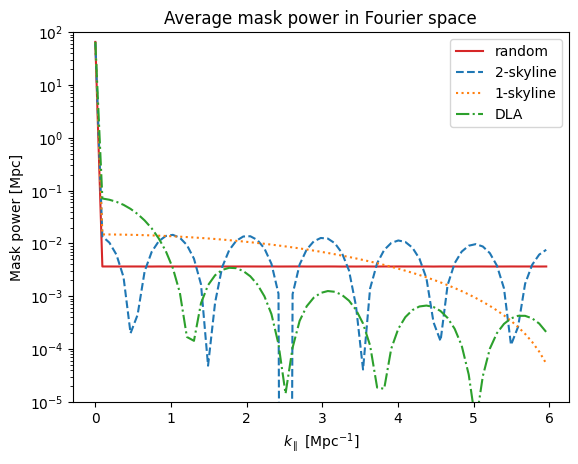

In [329]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.plot(kpar[:65], np.average(np.abs(random_mask_k[:, :65])**2, axis=0)*L/Np**2, label='random', color=colors[3])
plt.plot(kpar[:65], np.average(np.abs(skyline_2mask_k[:, :65])**2, axis=0)*L/Np**2, linestyle='dashed', label='2-skyline', color=colors[0])
plt.plot(kpar[:65], np.average(np.abs(skyline_mask_k[:, :65])**2, axis=0)*L/Np**2, linestyle='dotted', label='1-skyline', color=colors[1])
plt.plot(kpar[:65], np.average(np.abs(dla_mask_k[:, :65])**2, axis=0)*L/Np**2, linestyle='dashdot', label='DLA', color=colors[2])
# plt.plot(kpar[:65], np.average(np.abs(unmasked_fft[:, :65])**2, axis=0)*L/Np**2, linestyle='dashdot', label='unmasked')
plt.legend()
plt.ylim([1e-5,100])
plt.yscale('log')
plt.title("Average mask power in Fourier space")
plt.ylabel("Mask power [Mpc]")
plt.xlabel(r"$k_{\parallel}$ [Mpc$^{-1}$]")

In [11]:
# now recompute the delta_ks for the masked skewers
delta_flux_randmasked_k_grid = (np.fft.fft(delta_flux_randmasked_grid, axis=2))
# delete the pixel-space arrays to save memory
del delta_flux_randmasked_grid
delta_flux_skyline_k_grid = (np.fft.fft(delta_flux_skyline_grid, axis=2))
del delta_flux_skyline_grid
delta_flux_dla_k_grid = (np.fft.fft(delta_flux_dla_grid, axis=2))
del delta_flux_dla_grid
delta_flux_2skyline_k_grid = (np.fft.fft(delta_flux_2skyline_grid, axis=2))
del delta_flux_2skyline_grid
delta_flux_k_padded_grid = (np.fft.fft(delta_flux_grid, axis=2))

# reshape the masked arrays into 2D arrays
delta_flux_randmasked_k = np.reshape(delta_flux_randmasked_k_grid, (nskew, Nk))
delta_flux_skyline_k = np.reshape(delta_flux_skyline_k_grid, (nskew, Nk))
delta_flux_dla_k = np.reshape(delta_flux_dla_k_grid, (nskew, Nk))
delta_flux_2skyline_k = np.reshape(delta_flux_2skyline_k_grid, (nskew, Nk))
delta_flux_k_padded = np.reshape(delta_flux_k_padded_grid, (nskew, Nk))

In [12]:
kmax = np.pi/pix_spacing
kbin_spacing = kpar[1]-kpar[0]

# make a set of bins with kpar as centers
kbin_est = np.array([[kp-(kpar[1]-kpar[0])/2, kp+(kpar[1]-kpar[0])/2] for kp in kpar])
Nbin = len(kbin_est)

In [ ]:
# # plot the deltas of the DLA masked skewers vs the originals
# plt.figure()
# # i = 90
# i = 0
# for j in range(100):
#     # plt.plot(xpar_b, delta_flux_b_grid[i, i], label='original')
#     # plt.plot(xpar_b, delta_flux_dla_b_grid[i, i], label='DLA masked')
#     # plt.plot(xpar_b, delta_flux_2skyline_b_grid[i, i], label='2 skylines masked')
#     plt.plot(xpar_b, delta_flux_dla_b_grid.real[i, j]-delta_flux_b_grid.real[i, j], label='DLA masked')

#     # plt.plot(xpar_b, delta_flux_randmasked_b_grid.real[i, i]-delta_flux_b_grid.real[i, i], label='random masked')
#     # plt.plot(xpar_b, delta_flux_2skyline_b_grid[i, i]-delta_flux_b_grid[i,i], label='2 skylines masked')
#     plt.plot(xpar_b, delta_flux_skyline_b_grid.real[i, j]-delta_flux_b_grid.real[i,j], label='1 skylines masked')
#     plt.ylim([-.5,.3])
#     plt.legend()
#     plt.show()
#     plt.clf()

    # # plot the delta flux k
    # plt.plot(kpar_b,delta_flux_k_grid[i,j], label='original')
    # plt.plot(kpar_b,delta_flux_randmasked_k_grid[i,j], label='random masked')
    # plt.plot(kpar_b,delta_flux_skyline_k_grid[i,j], label='skyline masked')
    # plt.plot(kpar_b,delta_flux_dla_k_grid[i,j], label='DLA masked')
    # plt.plot(kpar_b,delta_flux_2skyline_k_flat[i,j], label='double skyline masked')
    # plt.legend()
    # plt.show()
    # plt.clf()

Text(0.5, 0.92, 'Random masking of 1-5 pixels in each skewer')

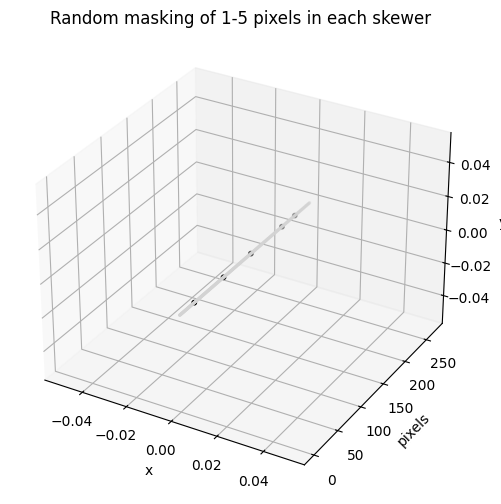

In [156]:
# visualize the masks
cm = plt.cm.jet
# 1: plot a 3D cube showing the masked pixel locations
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np), np.arange(Np), j*np.ones(Np), c='lightgrey', s=2)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(len(masklocs)), masklocs, j*np.ones(len(masklocs)), c='k', s=10)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Random masking of 1-5 pixels in each skewer")

Text(0.5, 0.92, 'Skyline-like masking')

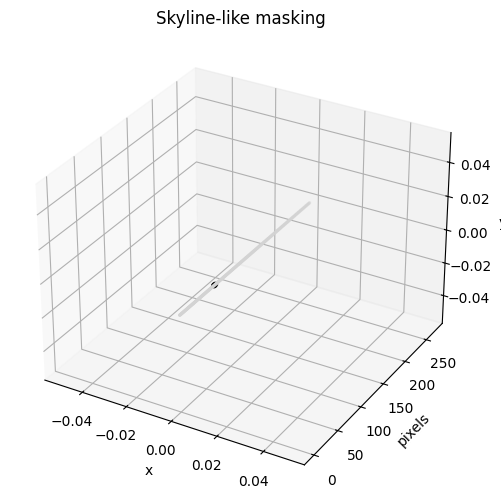

In [157]:
# 2: skyline visualization

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np), np.arange(Np), j*np.ones(Np), c='lightgrey', s=2, zorder=counter)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(skyline_width), sky_maskrange, j*np.ones(skyline_width), c='k', s=10, zorder=counter+1)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Skyline-like masking")

Text(0.5, 0.92, 'DLA-like masking')

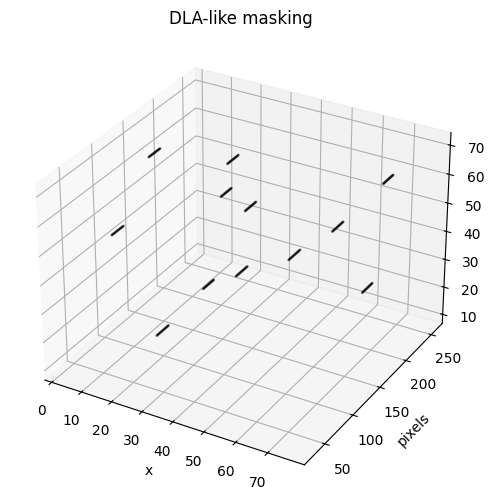

In [158]:
# 3: the DLA_like mask

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')

for c, dlax in enumerate(dla_locs_xx[::100]):
    dlay = dla_locs_yy[::100][c]
    ax.scatter(dlax*np.ones(dla_width), dla_locs_zstart[c]+np.arange(dla_width), dlay*np.ones(dla_width), c='k', alpha=.4, s=1)

ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("DLA-like masking")

Text(0.5, 0.92, 'Double-skyline-like masking')

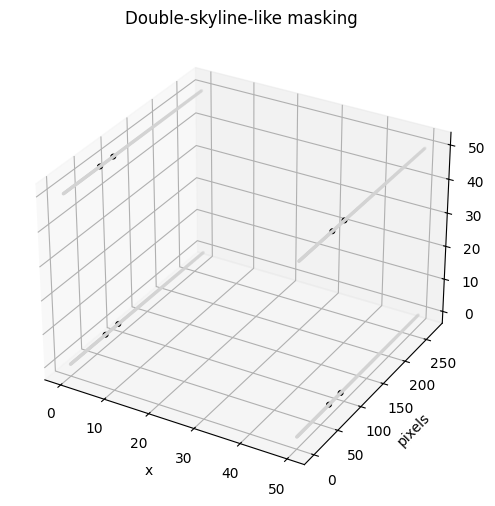

In [159]:
# 4: double-skyline visualization

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 50):
    for j in range(0, nside, 50): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np), np.arange(Np), j*np.ones(Np), c='lightgrey', s=2, zorder=counter)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(double_skyline_width), double_sky_maskrange, j*np.ones(double_skyline_width), c='k', s=10, zorder=counter+1)
            ax.scatter(i*np.ones(double_skyline_width), double_sky_maskrange+double_skyline_distance, j*np.ones(double_skyline_width), c='k', s=10, zorder=counter+1)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Double-skyline-like masking")

In [13]:
# Get the model P1D
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)

NameError: name 'arinyo' is not defined

Get the FFT measurements

In [14]:
p1d = np.ma.mean((delta_flux_k.__abs__())**2, axis=0)
p1d_padded = np.ma.mean((delta_flux_k_padded.__abs__())**2, axis=0)
p1d_randmasked = np.ma.mean((delta_flux_randmasked_k.__abs__())**2, axis=0)
p1d_skyline = np.ma.mean((delta_flux_skyline_k.__abs__())**2, axis=0)
p1d_dla = np.ma.mean((delta_flux_dla_k.__abs__())**2, axis=0)
p1d_2skyline = np.ma.mean((delta_flux_2skyline_k.__abs__())**2, axis=0)

In [15]:
# get the window function for correction
wk = est.w_k(kpar, pix_spacing)
# plt.plot(kpar_b, wk)

# # make a two-panel figure with the lower panel only 1/3 of the size
# fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})
# ax[0].plot(kpar_b, pk_avg/wk, '*', label='FFT, window correction')

# ax[0].plot(kpar_b, p1d_avg, '*', label='FFT, no window correction')
# ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')

# # plt.ylim([-1,1])
# plt.suptitle(r"$P_{1D}$ FFT pixel window effect")
# ax[0].set_xlim([0,6])
# ax[1].set_xlim([0,6])
# ax[0].legend()

# # plot the pct difference from no-masking in the lower panel
# ax[1].plot(kpar_b, (p1d_avg/wk-pk_avg)/pk_avg, linestyle='dotted')

# ax[1].set_ylim([-0.1, 0.1])

In [29]:
p1d[0], p1d_dla[0], p1d_2skyline[0], p1d_skyline[0], p1d_randmasked[0]

(453.7094042466951,
 446.93285718691953,
 447.8890286154183,
 453.5535563722445,
 441.31714195692734)

Text(0.5, 0, '$k_{\\parallel}$ [Mpc$^{-1}$]')

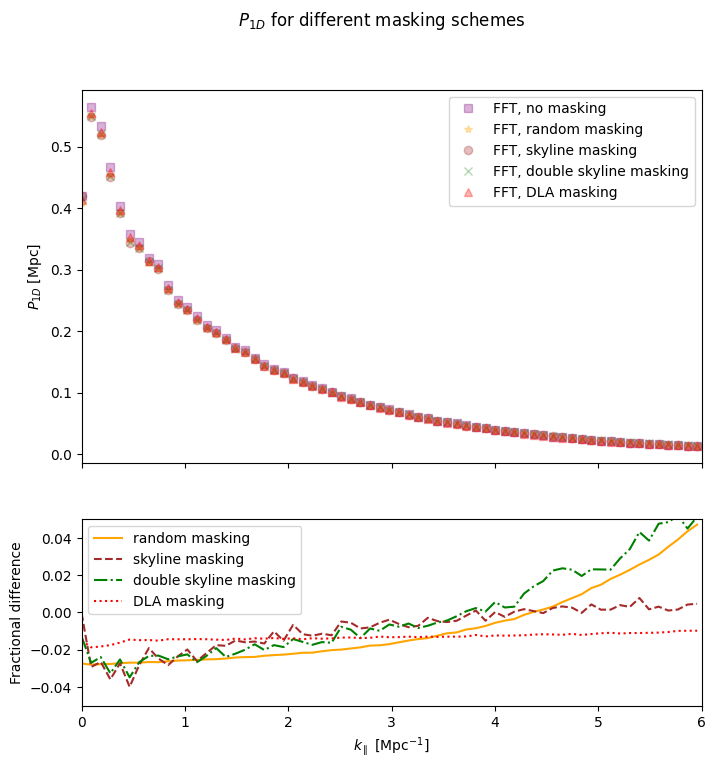

In [28]:
nmodes = 65
kpar_cut = kpar[:nmodes]
wkcut = wk[:nmodes]
#set of 5 colors
colors=['blue', 'orange', 'brown', 'green', 'red', 'purple']
# make a three-panel figure with the lower panels smaller
fig, ax = plt.subplots(2, 1, figsize=[8, 8], gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
# fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})

if pad:
    add_str = ", padded"
else:
    add_str = ""
ax[0].plot(kpar_cut, p1d[:nmodes]*L/Np**2/wkcut, 's', label='FFT, no masking', color=colors[5], alpha=.3)
if pad:
    ax[0].plot(kpar_cut, p1d_padded[:nmodes]*L/Np**2/wkcut, 's', label='FFT, padded masking', color=colors[0])
ax[0].plot(kpar_cut, p1d_randmasked[:nmodes]*L/Np**2/wkcut, '*', label=f'FFT, random masking{add_str}', color=colors[1], alpha=.3)
ax[0].plot(kpar_cut, p1d_skyline[:nmodes]*L/Np**2/wkcut, 'o', label=f'FFT, skyline masking{add_str}', color=colors[2], alpha=.3)
ax[0].plot(kpar_cut, p1d_2skyline[:nmodes]*L/Np**2/wkcut, 'x', label=f'FFT, double skyline masking{add_str}', color=colors[3], alpha=.3)
ax[0].plot(kpar_cut, p1d_dla[:nmodes]*L/Np**2/wkcut, '^', label=f'FFT, DLA masking{add_str}', color=colors[4], alpha=.3)

# ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim', color='k')
# ax[1].set_xscale('log')

# plt.ylim([-1,1])
plt.suptitle(r"$P_{1D}$ for different masking schemes")
ax[0].set_xlim([0,6])
ax[1].set_xlim([0,6])
ax[0].legend()
ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')

# plot the pct difference from no-masking in the lower panel
ax[1].plot(kpar_cut, (p1d_randmasked[:nmodes])/p1d[:nmodes]-1, linestyle='solid', color=colors[1], label='random masking')
ax[1].plot(kpar_cut, (p1d_skyline[:nmodes])/p1d[:nmodes]-1, linestyle='dashed', color=colors[2], label='skyline masking')
ax[1].plot(kpar_cut, (p1d_2skyline[:nmodes])/p1d[:nmodes]-1, linestyle='dashdot', color=colors[3], label='double skyline masking')
ax[1].plot(kpar_cut, (p1d_dla[:nmodes])/p1d[:nmodes]-1, linestyle='dotted', color=colors[4], label='DLA masking')
ax[1].legend()
ax[1].set_ylim([-0.05, 0.05])
ax[1].set_ylabel('Fractional difference')
ax[1].set_xlabel(r"$k_{\parallel}$ [Mpc$^{-1}$]")


In [210]:
def model_mask(nmodes, mask, p1d):
    masked_p1d_est = np.zeros(nmodes)
    for m in range(nmodes):
        if m%10==0:
            print("Getting model for mode", m)
        masked_p1d_est[m] = mc.calculate_masked_power_fft(m, mask, p1d)
    return masked_p1d_est

def plot_mask_model(nmodes, kpar, original_power, masked_power, masked_power_model, label, L=L, Np=Np):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
    kpar_cut = kpar[:nmodes]
    ax[0].plot(kpar_cut, original_power[:nmodes]*L/Np**2, label='original', color='blue')
    ax[0].plot(kpar_cut, masked_power[:nmodes]*L/Np**2, label='after ' + label+ ' masking', color='orange')
    ax[0].plot(kpar_cut, masked_power_model*L/Np**2, linestyle='dotted', label='model of masked power', color='green')
    # ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')
    # ax[0].plot(kpar_cut, np.abs(skyline_2mask_k_flat[0, :nmodes])*L/Np**2, label='mask FFT')
    ax[0].set_ylim([0,.6])
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[1].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
    ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
    ax[0].set_xlim([.1,6])
    ax[1].plot(kpar_cut, masked_power[:nmodes]/original_power[:nmodes]-1, label='masked vs original', color='orange')
    ax[1].plot(kpar_cut, masked_power_model[:nmodes]/masked_power[:nmodes]-1, label='model vs masked', color='green')
    ax[1].legend(loc=[.03, .8], framealpha=1)
    ax[1].set_ylabel("Fractional difference")
    ax[1].axhspan(-.01, .01, color='grey', alpha=0.5)
    ax[1].set_ylim([-.05,.05])
    plt.show()
    plt.clf()

Getting model for mode 0
Getting model for mode 10
Getting model for mode 20
Getting model for mode 30
Getting model for mode 40
Getting model for mode 50
Getting model for mode 0
Getting model for mode 10
Getting model for mode 20
Getting model for mode 30
Getting model for mode 40
Getting model for mode 50
Getting model for mode 0
Getting model for mode 10
Getting model for mode 20
Getting model for mode 30
Getting model for mode 40
Getting model for mode 50
Getting model for mode 0
Getting model for mode 10
Getting model for mode 20
Getting model for mode 30
Getting model for mode 40
Getting model for mode 50


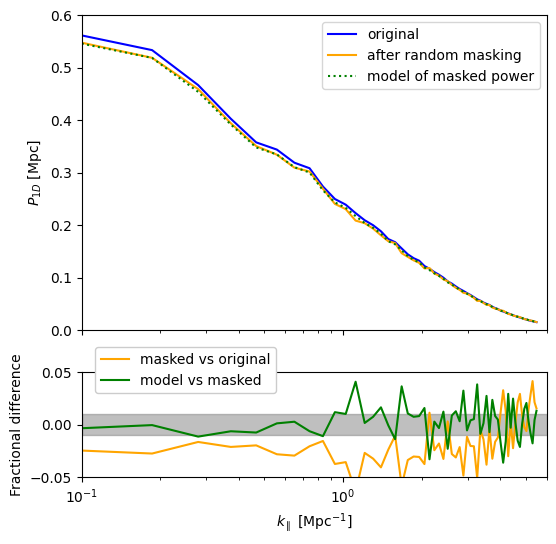

<Figure size 640x480 with 0 Axes>

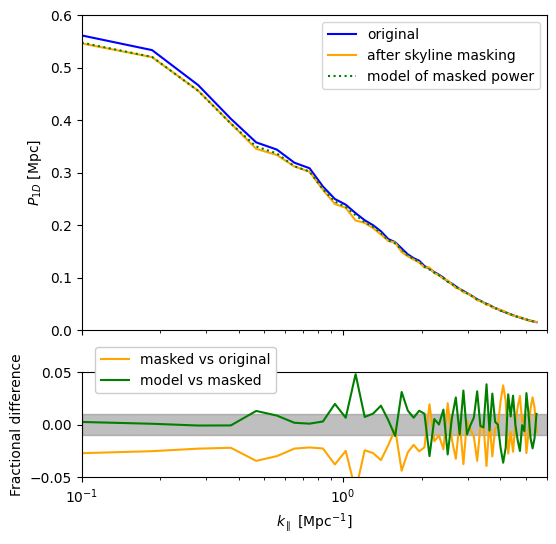

<Figure size 640x480 with 0 Axes>

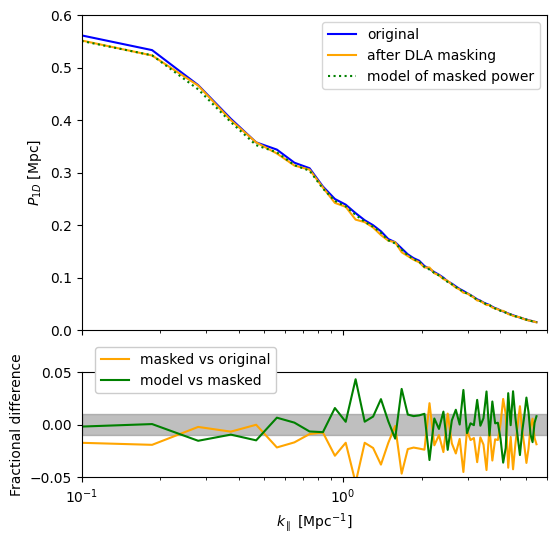

<Figure size 640x480 with 0 Axes>

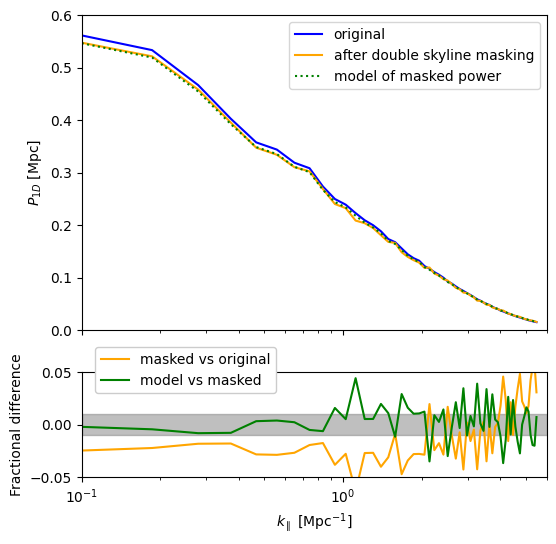

<Figure size 640x480 with 0 Axes>

In [211]:
nmodes = 60
model_2skyline = model_mask(nmodes, skyline_2mask_k, p1d)
model_dla = model_mask(nmodes, dla_mask_k, p1d)
model_rand = model_mask(nmodes, random_mask_k, p1d)
model_skyline = model_mask(nmodes, skyline_mask_k, p1d)

plot_mask_model(nmodes, kpar, p1d, p1d_randmasked, model_rand, 'random', L=L, Np=Np)
plot_mask_model(nmodes, kpar, p1d, p1d_skyline, model_skyline, 'skyline', L=L, Np=Np)
plot_mask_model(nmodes, kpar, p1d, p1d_dla, model_dla, 'DLA', L=L, Np=Np)
plot_mask_model(nmodes, kpar, p1d, p1d_2skyline, model_2skyline, 'double skyline', L=L, Np=Np)


In [212]:
print("Lowest k mode that can be measured with full box is ", kpar[1], 2*np.pi/L, "the fundamental frequency")

Lowest k mode that can be measured with full box is  0.0930842267730309 0.09308422677303091 the fundamental frequency


In [255]:
# confirm that the optimal estimator produces an unbiased result
# do the setup
delta_x_matrix = est.make_delta_x_matrix(L, Np, xpar)
S_fiducial = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix, pix_spacing, plot=False)
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
xi_fid = np.fft.irfft(p1d_fine) / spacing_fine
xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C_0_mat = est.c0(xi_fid_func, delta_x_matrix)
C_0_invmat = np.linalg.inv(C_0_mat)

In [225]:
# do the fiducial measurement
kbin_centers, theta_est_p1d, F_alpha_beta_p1d, Lalpha_P1D = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_grid, kbin_est[:25], S_fiducial, C_0_invmat, approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324, 1.3962634015954634, 1.4893476283684943, 1.5824318551415253, 1.675516081914556, 1.768600308687587, 1.8616845354606177, 1.9547687622336487, 2.0478529890066794, 2.1409372157797106, 2.2340214425527414]
Getting derivative matrices.
Starting loop through data.
This k took 11.471966981887817 seconds
This k took 9.909932136535645 seconds
This k took 16.589059114456177 seconds
This k took 13.05282711982727 seconds
This k took 18.96342134475708 seconds
This k took 18.215703010559082 seconds
This k took 13.201503992080688 seconds
This k took 12.4863121509552 seconds
This k took 10.199319839477539 seconds
This k took 9.712335109710693 seconds
This k took 12.739845037460327 seconds
Thi

In [278]:
# do the masked measurements
kbin_centers, theta_est_p1d_rand, F_alpha_beta_p1d_rand, Lalpha_P1D_rand = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_randmasked_grid, kbin_est[:15], S_fiducial, C_0_invmat, C_0_mat=C_0_mat, weights=1/(random_mask+1e-5), approx_fisher=True)


Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324]
Getting derivative matrices.
Starting loop through data.
This k took 20.06328010559082 seconds
This k took 25.390316009521484 seconds
This k took 19.718116998672485 seconds
This k took 29.863620042800903 seconds
This k took 22.34372901916504 seconds
This k took 21.933873891830444 seconds
This k took 24.367255687713623 seconds
This k took 30.966569900512695 seconds
This k took 23.83536982536316 seconds
This k took 27.195455074310303 seconds
This k took 22.179786205291748 seconds
This k took 27.386509895324707 seconds
This k took 24.362816095352173 seconds
This k took 17.988892078399658 seconds
This k took 23.26703691482544 seconds


In [289]:
kbin_centers, theta_est_p1d_skyline, F_alpha_beta_p1d_skyline, Lalpha_P1D_skyline = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_skyline_grid, kbin_est[:15], S_fiducial, C_0_invmat,C_0_mat=C_0_mat,  weights=1/(skyline_mask+1e-5), approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324]
Getting derivative matrices.
Starting loop through data.
This k took 26.582276105880737 seconds
This k took 39.77098298072815 seconds
This k took 34.73501372337341 seconds
This k took 34.26375603675842 seconds
This k took 24.36147403717041 seconds
This k took 24.123600721359253 seconds
This k took 28.782420873641968 seconds
This k took 31.133329153060913 seconds
This k took 37.090906858444214 seconds
This k took 34.70977306365967 seconds
This k took 30.74790620803833 seconds
This k took 27.021751880645752 seconds
This k took 28.13994598388672 seconds
This k took 26.83265209197998 seconds
This k took 21.78049111366272 seconds


In [292]:
kbin_centers, theta_est_p1d_2skyline, F_alpha_beta_p1d_2skyline, Lalpha_P1D_2skyline = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_2skyline_grid, kbin_est[:15], S_fiducial, C_0_invmat,C_0_mat=C_0_mat,  weights=1/(skyline_2mask+1e-5), approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324]
Getting derivative matrices.
Starting loop through data.
This k took 22.828445196151733 seconds
This k took 20.60446572303772 seconds
This k took 24.44278597831726 seconds
This k took 22.28462505340576 seconds
This k took 25.761786937713623 seconds
This k took 26.210994958877563 seconds
This k took 23.809076070785522 seconds
This k took 21.34253215789795 seconds
This k took 21.76136088371277 seconds
This k took 28.216991901397705 seconds
This k took 34.29638695716858 seconds
This k took 28.285340785980225 seconds
This k took 33.32581663131714 seconds
This k took 25.271300792694092 seconds
This k took 16.9674870967865 seconds


In [ ]:
kbin_centers, theta_est_p1d_dla, F_alpha_beta_p1d_dla, Lalpha_P1D_dla = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_dla_grid, kbin_est[:25], S_fiducial, C_0_invmat, approx_fisher=True)

In [236]:
Nbin//2

135

In [246]:
p1d_fid = est.bin_model(kfine, p1d_fine, kbin_est[:135], Nbin//2-2)

In [290]:
kbin_centers = [(k[0]+k[1])/2. for k in kbin_est]


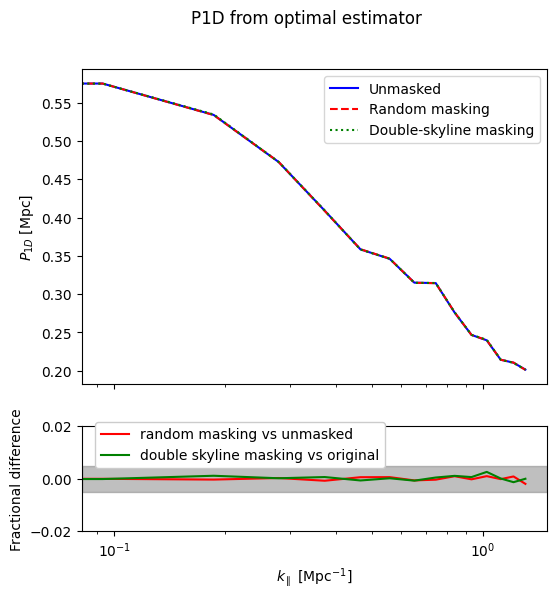

<Figure size 640x480 with 0 Axes>

In [301]:
nmodes = 15
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
kpar_cut = kbin_centers[:nmodes]
plt.suptitle("P1D from optimal estimator")
ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d[:nmodes], label='Unmasked', color='blue')
ax[0].plot(kpar_cut[:nmodes], p1d_fid[:nmodes]+theta_est_p1d_rand[:nmodes], label='Random masking', linestyle='dashed', color='red')
ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_2skyline[:nmodes], label='Double-skyline masking', linestyle='dotted', color='green')
ax[1].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
# ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_skyline[:nmodes], label='skyline masked')
# ax[0].plot(kpar_cut, theta_est_p1d_2skyline[:nmodes], label='double skyline masked')
# ax[0].plot(kpar_cut, theta_est_p1d_dla[:nmodes], label='DLA masked')
ax[1].plot(kpar_cut, (p1d_fid[:nmodes]+theta_est_p1d_rand[:nmodes])/(p1d_fid[:nmodes]+theta_est_p1d[:nmodes])-1, label='random masking vs unmasked', color='red')
ax[1].plot(kpar_cut, (p1d_fid[:nmodes]+theta_est_p1d_2skyline[:nmodes])/(p1d_fid[:nmodes]+theta_est_p1d[:nmodes])-1, label='double skyline masking vs original', color='green')
# ax[1].plot(kpar_cut, theta_est_p1d_2skyline[:nmodes]/theta_est_p1d[:nmodes]-1, label='double skyline masked vs original', color='purple')
# ax[1].plot(kpar_cut, theta_est_p1d_dla[:nmodes]/theta_est_p1d[:nmodes]-1, label='DLA masked vs original', color='red')
ax[1].legend(loc=[.03, .6], framealpha=1)
ax[1].set_ylabel("Fractional difference")
ax[1].axhspan(-.005, .005, color='grey', alpha=0.5)
ax[1].set_ylim([-.02,.02])
ax[0].legend()
ax[1].set_xscale('log')

plt.show()
plt.clf()
